# Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/CS231.M11 Final Project"

/content/drive/MyDrive/CS231.M11 Final Project


# Install necessary library

In [ ]:
!git clone https://github.com/thelahunginjeet/pyrankagg.git

Cloning into 'pyrankagg'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 142 (delta 2), reused 3 (delta 1), pack-reused 136
Receiving objects: 100% (142/142), 200.01 KiB | 6.25 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
!git clone https://github.com/thelahunginjeet/kbutil.git

Cloning into 'kbutil'...
remote: Enumerating objects: 247, done.
remote: Total 247 (delta 0), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (247/247), 55.14 KiB | 1.90 MiB/s, done.
Resolving deltas: 100% (155/155), done.


# Import library

In [ ]:
from keras.preprocessing import image
from keras.applications.resnet_v2 import ResNet50V2
from keras.models import Model
import numpy as np
import pandas as pd
import os,glob
import cv2
import scipy
import pickle as pickle
import random
from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import requests
from scipy import integrate
from tqdm import tqdm_notebook

In [ ]:
path_database ='/content/drive/MyDrive/CS231.M11 Final Project/dataset'
path = './'

# Extract feature of image using ResNet50

In [ ]:
# Tài liệu về mô hình pretrained ResNet50V2
from google.colab.patches import cv2_imshow
base_model = ResNet50V2(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
img_size = 224
# function extract_features có nhiệm vụ trích xuất đặc trưng của từng loại ảnh
def extract_features(img_path, choice):  # img is from PIL.Image.open(path) or keras.preprocessing.image.load_img(path)
    if choice == 'invert': # tạo ảnh âm bản
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.bitwise_not(img)
    elif choice == 'gray': # tạo ảnh trắng đen
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
    elif choice == 'invert-gray': # ảnh âm bản của trắng đen
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size)) 
        # img = cv2.bitwise_not(img)
    else:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_size, img_size))
    
    if choice in ['gray', 'invert-gray']:
        img = np.stack((img,)*3, axis=-1)

    x = np.array(img) / 255
    # Reshaping data từ 1 chiều thành 3 chiều
    x = x.reshape(-1, img_size, img_size, 3)
    feature = model.predict(x)[0]  # (1, 4096) -> (4096, )
    return feature / np.linalg.norm(feature)  # Normalize

102883328/102869336 [==============================] - 1s 0us/step


# Handle extract feature all images in dataset base on types

In [ ]:
#đọc tất cả bức ảnh trong cơ sở dữ liệu, sau đó rút trích đặc trưng biểu diễn lưu thông tin lại
path_features = '/content/drive/MyDrive/CS231.M11 Final Project/features/'
def batch_extractor(urls, prefix_pickled_db_path="features_", types=None):
    # types = ['invert', 'gray', 'invert-gray']
    for t in types: # lần lượt convert qua các loại
        result = {}
        count = 0
        print('Dang xu ly dang: ', t)
        for url in tqdm_notebook(urls):
            # try:
                name = url
                # print("name True: ", name)
                result[name] = extract_features(url, t) # mảng result có dạng: [image1_url:vector1, image2_url: vector2]
                count +=1
            # except:
            #     print(url)
            # continue

        print("So luong nhan trong CSDL: ", count)
        # Lưu các đặc trưng biểu diễn bức ảnh dưới dạng file pickle
        with open(path_features + prefix_pickled_db_path + t + '.pck', 'wb') as fp:
            pickle.dump(result, fp)

# Get path of all image in dataset

In [ ]:
# Đọc dữ liệu từ đường dẫn và lưu nhãn của nó
labels = ['dandelion', 'daisy','tulip','sunflower','rose', "hibiscus", "heavenly flower", "cherry blossom", "phoenix", "lily", "lagerstroemia", "cats", "dogs", "tiger", "hyena", "jaguar"]
img_size = 224
def get_data(data_dir):
    urls = [] 
    # for label in labels:
    #     print("Đang đọc dữ liệu của nhãn :", label)
    #     path = os.path.join(data_dir, label)
    #     for img in glob.glob(path + "/*.jpg"):
    #       path_img = img
    #       urls.append(path_img)
    for img in glob.glob(path_database + "/*.jpg"):
      path_img = img
      urls.append(path_img)
    return urls
urls = get_data(path_database)

# Excecute extract feature base on types

In [ ]:
types = ['normal','invert', 'gray', 'invert-gray']
batch_extractor(urls, types=types)

Dang xu ly dang:  normal


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/4738 [00:00<?, ?it/s]

So luong nhan trong CSDL:  4738


# Search Engine

In [ ]:
# Đây là tạo đối tượng tìm kiếm ảnh trong cơ sở đữ liệu.
# Đầu tiên các ma trận vector trong cơ sở dữ liệu
from pyrankagg.rankagg import PartialListRankAggregator

class Search_Engine(object):
    def __init__(self, 
                 pickled_db_normal="/content/drive/MyDrive/CS231.M11 Final Project/features/features_normal.pck",
                 pickled_db_invert="/content/drive/MyDrive/CS231.M11 Final Project/features/features_invert.pck",
                 pickled_db_gray="/content/drive/MyDrive/CS231.M11 Final Project/features/features_gray.pck",
                 pickled_db_gray_invert="/content/drive/MyDrive/CS231.M11 Final Project/features/features_invert-gray.pck"):
        
        self.dict_db_features = {
                              "normal": {'path_data': pickled_db_normal}, 
                              "invert": {'path_data': pickled_db_invert}, 
                              "gray": {'path_data': pickled_db_gray}, 
                              "invert-gray": {'path_data': pickled_db_gray_invert}} # dict lưu feature các loại ảnh
        # Đọc các vector ảnh theo từng loại
        for t in self.dict_db_features:
            with open(self.dict_db_features[t]['path_data'], "rb") as fp:
                self.dict_db_features[t]['features'] = pickle.load(fp)

            self.dict_db_features[t]['name'] = []
            self.dict_db_features[t]['matrix'] = []
            # k: image path
            # v: vector
            for k, v in self.dict_db_features[t]['features'].items():
                self.dict_db_features[t]['name'].append(k)
                self.dict_db_features[t]['matrix'].append(v)
            
            self.dict_db_features[t]['matrix'] = np.array(self.dict_db_features[t]['matrix'])
            self.dict_db_features[t]['name'] = np.array(self.dict_db_features[t]['name'])
        print(self.dict_db_features["normal"])

    # Tinh khoang cach cosine giua vector truy van va cac vector trong du lieu
    def cos_cdist(self, vector, t):
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.dict_db_features[t]['matrix'], v, 'cosine').reshape(-1)

    def borda_sort(lists):
        scores = {}
        for l in lists:
            for idx, elem in enumerate(reversed(l)):
                if not elem in scores:
                    scores[elem] = 0
                scores[elem] += idx
        return sorted(scores.keys(), key=lambda elem: scores[elem], reverse=True)

    # Tim kiem du lieu 
    def match(self, image_path, topn=5):
        PLRA = PartialListRankAggregator()
        choice = ['normal', 'invert', 'gray', 'invert-gray']
        features = {}
        for c in choice:
            features[c] = extract_features(image_path, c) # đọc từng loại ảnh trong list choice
        
        similarity = {'normal': {}, 'invert': {}, 'gray': {}, 'invert-gray': {}}
        for c in choice:
            similarity[c]['cosine_distance'] = self.cos_cdist(features[c], c) # lấy ra cosine distance của từng loại
            similarity[c]['nearest_ids'] = np.argsort(similarity[c]['cosine_distance'])[:topn].tolist() # sort lại rồi lấy topn đầu tiên
            similarity[c]['nearest_img_paths'] = self.dict_db_features[c]['name'][similarity[c]['nearest_ids']].tolist() # lấy ra tên ảnh

        list_rank = [] # chứa score cosine của 4 loại
        list_score = []
        dict_scores = {}
        for c in choice:
            dict_name_with_rank = {} # Tạo 1 dict gồm cặp key - value là tên ảnh - score cosine
            dict_name_with_scores = {}
            imgs_name = similarity[c]['nearest_img_paths']
            cosine_scores = similarity[c]['cosine_distance'][similarity[c]['nearest_ids']]
            for i in range(0, len(imgs_name)):
                # dict_name_with_score[imgs_name[i]] = 1 - cosine_scores[i]
                dict_name_with_rank[imgs_name[i]] = i + 1
                dict_name_with_scores[imgs_name[i]] = 1 - cosine_scores[i]
                if imgs_name[i] not in dict_scores:
                    dict_scores[imgs_name[i]] = [1 - cosine_scores[i]]
                else:
                    dict_scores[imgs_name[i]].append(1 - cosine_scores[i])

            list_rank.append(dict_name_with_rank)
            list_score.append(dict_name_with_scores)

        _, aggRanks = PLRA.aggregate_ranks(list_rank)

        final_scores = []
        aggRanks = {k: v for k, v in sorted(aggRanks.items(), key=lambda item: item[1])} # sort dict by values
        for img in aggRanks.keys():
            final_scores.append(max(dict_scores[img]))

        # lấy ra score của các ảnh
        return list(aggRanks.keys())[:topn], final_scores, list_score

# Convert all images in dataset into 4 channels and save to another folder


*   normal
*   invert
*   gray
*   invert-gray



In [ ]:
dir_data = '/content/drive/MyDrive/CS231.M11 Final Project/dataset'
dir_save = '/content/drive/MyDrive/CS231.M11 Final Project/types'
import glob
import tqdm
import cv2

def read_img(img_path, choice):  # img is from PIL.Image.open(path) or keras.preprocessing.image.load_img(path)
    if choice == 'invert': # tạo ảnh âm bản
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.bitwise_not(img)
    elif choice == 'gray': # tạo ảnh trắng đen
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    elif choice == 'invert-gray': # ảnh âm bản của trắng đen
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.bitwise_not(img)
    else:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    return img

list_imgs = glob.glob(dir_data + '/*.jpg')
for path_img in tqdm.notebook.tqdm(list_imgs):
    img_name = os.path.split(path_img)[-1]
    cls = os.path.split(os.path.split(path_img)[0])[-1]
    for t in ['normal', 'invert', 'gray', 'invert-gray']:
        if not os.path.exists(dir_save):
            os.mkdir(dir_save)
        img = read_img(path_img, t)
        try:
            print(os.path.join(dir_save,t,img_name))
            cv2.imwrite(os.path.join(dir_save,t,img_name), img)
        except:
            pass

# Handle query similar images from input image

In [ ]:
# Đoạn code hiển thị kết quả ảnh
def show_img(img_path):
    # img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

# Chương trình chạy code dự đoán.
def run(path_query, topn = 10, path_database=None):
    searcher = Search_Engine()
    print('Anh truy van')
    show_img(path_query)
    names, match, all_queries = searcher.match(path_query, topn=topn)
    
    print(all_queries)
    print('Kết quả truy vấn normal')
    normal_queries = all_queries[0]
    for i, img in enumerate(normal_queries):
        print("So thu tu: " +  str(i+1)  + " Tuong dong: " + str((match[i])))
        print(os.path.join(path_database, 'normal', os.path.split(names[i])[-1]))
        show_img(os.path.join(path_database, 'normal', os.path.split(names[i])[-1]))
        # show_img(os.path.join(path_database,os.path.split(names[i])[-1]))

    print('##################################################################################')
    print('Kết quả truy vấn âm bản')
    invert_queries = all_queries[1]
    for i, img in enumerate(invert_queries):
        print("So thu tu: " +  str(i+1)  + " Tuong dong: " + str((match[i])))
        show_img(os.path.join(path_database, 'invert', os.path.split(names[i])[-1]))

    print('##################################################################################')
    print('Kết quả truy vấn trắng đen')
    gray_queries = all_queries[2]
    for i, img in enumerate(gray_queries):
        print("So thu tu: " +  str(i+1)  + " Tuong dong: " + str((match[i])))
        show_img(os.path.join(path_database, 'gray', os.path.split(names[i])[-1]))

    print('##################################################################################')
    print('Kết quả truy vấn âm bản-trắng đen')
    invert_gray_queries = all_queries[3]
    for i, img in enumerate(invert_gray_queries):
        print("So thu tu: " +  str(i+1)  + " Tuong dong: " + str((match[i])))
        show_img(os.path.join(path_database, 'invert-gray', os.path.split(names[i])[-1]))

    print('##################################################################################')
    print('Kết quả truy vấn chung')
    for i in range(topn):
        print("So thu tu: " +  str(i+1)  + " Tuong dong: " + str((match[i])))
        show_img(os.path.join(path_database, 'normal' ,os.path.split(names[i])[-1]))
        # show_img(os.path.join(path_database,os.path.split(names[i])[-1]))

# Execute query similar images from input image

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



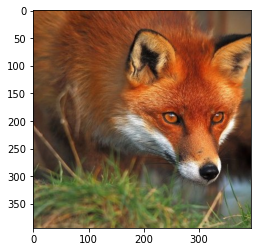

[{'/content/drive/MyDrive/CS231.M11 Final Project/dataset/2968.jpg': 0.9943485022830695, '/content/drive/MyDrive/CS231.M11 Final Project/dataset/239.jpg': 0.9940314661786847, '/content/drive/MyDrive/CS231.M11 Final Project/dataset/448.jpg': 0.9908133198162196, '/content/drive/MyDrive/CS231.M11 Final Project/dataset/3324.jpg': 0.9906988808576453, '/content/drive/MyDrive/CS231.M11 Final Project/dataset/1224.jpg': 0.984716807315243}, {'/content/drive/MyDrive/CS231.M11 Final Project/dataset/2820.jpg': 0.9999996334849238, '/content/drive/MyDrive/CS231.M11 Final Project/dataset/4350.jpg': 0.9999981320979319, '/content/drive/MyDrive/CS231.M11 Final Project/dataset/782.jpg': 0.9999979291378849, '/content/drive/MyDrive/CS231.M11 Final Project/dataset/1642.jpg': 0.9999976895308765, '/content/drive/MyDrive/CS231.M11 Final Project/dataset/3094.jpg': 0.9999974929828909}, {'/content/drive/MyDrive/CS231.M11 Final Project/dataset/2322.jpg': 0.9973277659093301, '/content/drive/MyDrive/CS231.M11 Final P

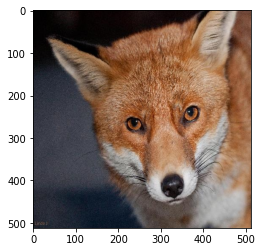

So thu tu: 2 Tuong dong: 0.9973277659093301
/content/drive/MyDrive/CS231.M11 Final Project/types/normal/2322.jpg


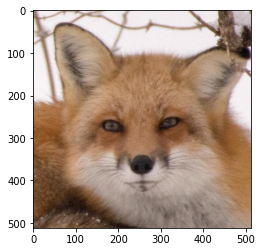

So thu tu: 3 Tuong dong: 0.985704657712211
/content/drive/MyDrive/CS231.M11 Final Project/types/normal/615.jpg


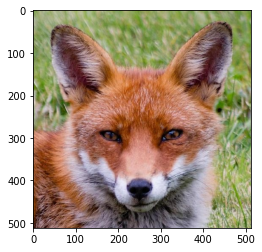

So thu tu: 4 Tuong dong: 0.9999996334849238
/content/drive/MyDrive/CS231.M11 Final Project/types/normal/2820.jpg


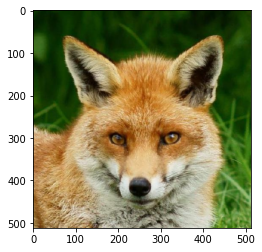

So thu tu: 5 Tuong dong: 0.9943485022830695
/content/drive/MyDrive/CS231.M11 Final Project/types/normal/2968.jpg


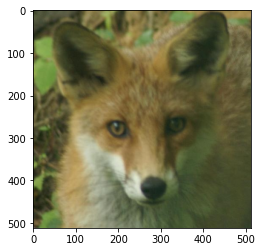

##################################################################################
Kết quả truy vấn âm bản
So thu tu: 1 Tuong dong: 0.9999979291378849


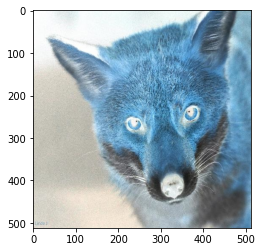

So thu tu: 2 Tuong dong: 0.9973277659093301


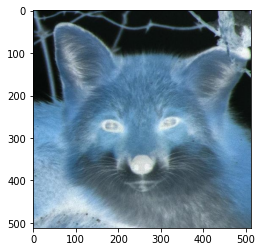

So thu tu: 3 Tuong dong: 0.985704657712211


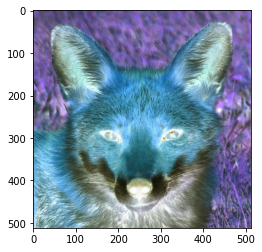

So thu tu: 4 Tuong dong: 0.9999996334849238


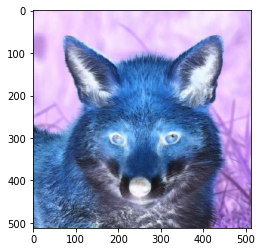

So thu tu: 5 Tuong dong: 0.9943485022830695


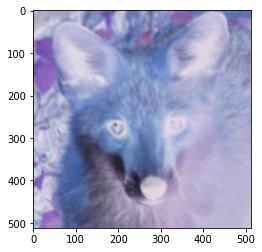

##################################################################################
Kết quả truy vấn trắng đen
So thu tu: 1 Tuong dong: 0.9999979291378849


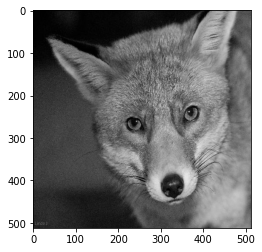

So thu tu: 2 Tuong dong: 0.9973277659093301


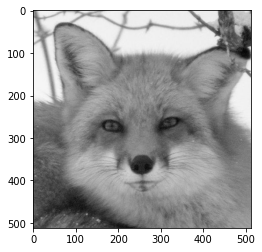

So thu tu: 3 Tuong dong: 0.985704657712211


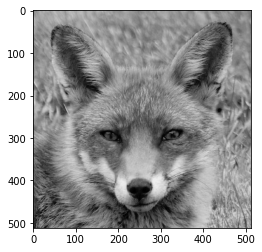

So thu tu: 4 Tuong dong: 0.9999996334849238


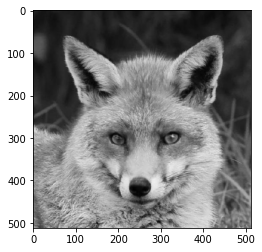

So thu tu: 5 Tuong dong: 0.9943485022830695


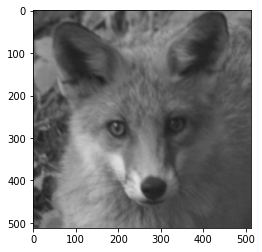

##################################################################################
Kết quả truy vấn âm bản-trắng đen
So thu tu: 1 Tuong dong: 0.9999979291378849


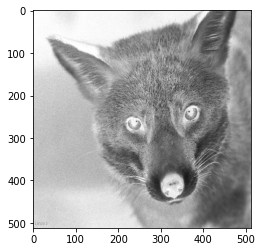

So thu tu: 2 Tuong dong: 0.9973277659093301


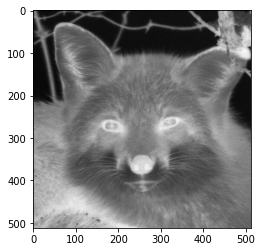

So thu tu: 3 Tuong dong: 0.985704657712211


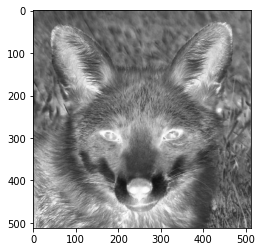

So thu tu: 4 Tuong dong: 0.9999996334849238


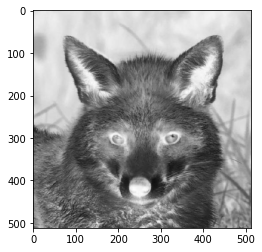

So thu tu: 5 Tuong dong: 0.9943485022830695


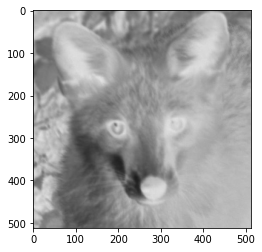

##################################################################################
Kết quả truy vấn chung
So thu tu: 1 Tuong dong: 0.9999979291378849


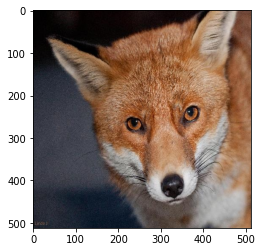

So thu tu: 2 Tuong dong: 0.9973277659093301


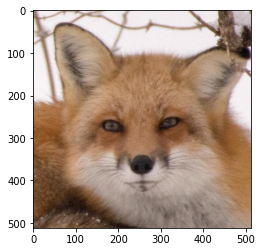

So thu tu: 3 Tuong dong: 0.985704657712211


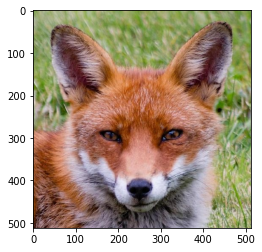

So thu tu: 4 Tuong dong: 0.9999996334849238


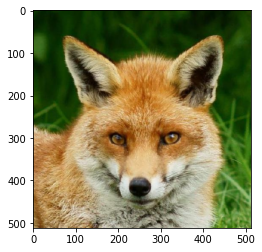

So thu tu: 5 Tuong dong: 0.9943485022830695


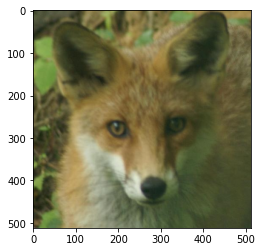

In [ ]:
path_database = '/content/drive/MyDrive/CS231.M11 Final Project/types'
path_query = '/content/drive/MyDrive/CS231.M11 Final Project/testimage/fox.jpg'
run(path_query, 5, path_database)

# SERVER (No need to execute)

In [ ]:
%cd "/content/drive/MyDrive/CS231.M11 Final Project/demo project/demoflask"

/content/drive/MyDrive/CS231.M11 Final Project/demo project/demoflask


In [ ]:
!pip install flask-ngrok

In [ ]:
from flask import Flask, request, jsonify, render_template, make_response,send_file
import base64
from flask_ngrok import run_with_ngrok
from flask import request
import cv2
import pickle
import os
import os , io , sys

from PIL import Image

app = Flask(__name__)
run_with_ngrok(app)   
# project_path="/content/drive/MyDrive/CS231.M11 Final Project/demo project/demoflask"
# model = pickle.load(open(os.path.join(project_path,"model.pkl"), 'rb'))


@app.route('/')
def home():
    # return "<h1>hello</h1>"
    return render_template('index.html')
@app.route("/get_image")
def get_image():
      img=cv2.imread("/content/drive/MyDrive/CS231.M11 Final Project/testimage/fox.jpeg")
      img = Image.fromarray(img.astype("uint8"))
      rawBytes = io.BytesIO()
      img.save(rawBytes, "JPEG")
      rawBytes.seek(0)
      img_base64 = base64.b64encode(rawBytes.read())
      # response = make_response(base64.b64encode(image_binary))
      # response.headers.set('Content-Type', 'image/jpg')
      # response.headers.set('Content-Disposition', 'attachment', filename='fox.jpg')
      # print("response",base64.b64encode(image_binary))
      return jsonify({'image':str(img_base64)})
@app.route('/predict',methods=['POST','GET'])
def predict():

    int_features = [int(x) for x in request.form.values()]
    final_features = [np.array(int_features)]
    prediction = model.predict(final_features)

    output = round(prediction[0], 2)

    return render_template('/content/drive/MyDrive/CS231.M11 Final Project/demo project/demoflask/templates/index.html', prediction_text='CO2EMISSIONS should be $ {}'.format(output))


if __name__ == "__main__":
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://1a69-35-185-15-66.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [16/Nov/2021 16:06:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2021 16:06:17] "GET /static/style.css HTTP/1.1" 404 -
127.0.0.1 - - [16/Nov/2021 16:06:18] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Nov/2021 16:06:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2021 16:06:19] "GET /static/style.css HTTP/1.1" 404 -
127.0.0.1 - - [16/Nov/2021 16:06:20] "GET /static/style.css HTTP/1.1" 404 -
127.0.0.1 - - [16/Nov/2021 16:06:22] "GET /get_image HTTP/1.1" 200 -
